In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image

In [2]:
tf.reset_default_graph()
def unpool_with_with_argmax(pooled, ind, out_shape):
    
    m,h,w,c = out_shape
    _,h_,w_,c_ = pooled.shape.as_list()
    
    unpool = tf.Variable(tf.zeros([m*h*w*c]))
    pooled_ = tf.reshape(pooled,[m,h_*w_*c_])
    pooled_ = tf.cast(pooled_,tf.float32)
    ind_ = tf.reshape(ind,[m,h_*w_*c_])
    
    for i in range(m):
        ref = tf.Variable(tf.zeros([m*h*w*c],tf.float32))
        indices= tf.expand_dims(ind_[i],axis=1)
        update = tf.compat.v1.scatter_nd_update(ref,indices=indices,updates=pooled_[i])
        unpool = tf.add(unpool,update)
    unpool = tf.reshape(unpool,(m,h,w,c))
    return unpool

In [3]:
def Normal(deconv):
    deconv_out = ((deconv - tf.reduce_min(deconv))) / (tf.reduce_max(deconv) - tf.reduce_min(deconv))
    deconv_out = tf.cast(deconv_out,tf.float32)
    return deconv_out

In [4]:
img = Image.open('/Users/huwang/Joker/Data_Set/catVSdot/test/7.jpg')
img = img.resize((227,227))
img = np.array(img) / 255
img = img.reshape((1,227,227,3))

In [6]:
sess = tf.Session()
new_saver = tf.train.import_meta_graph('../Model_AlexNet/alexnet.meta')
new_saver.restore(sess, '../Model_AlexNet/alexnet')
graph = tf.get_default_graph()
W1 = graph.get_tensor_by_name('W%d:0'%(1))
b1 = graph.get_tensor_by_name('b%d:0'%(1))
W2 = graph.get_tensor_by_name('W%d:0'%(2))
b2 = graph.get_tensor_by_name('b%d:0'%(2))
W3 = graph.get_tensor_by_name('W%d:0'%(3))
b3 = graph.get_tensor_by_name('b%d:0'%(3))
W4 = graph.get_tensor_by_name('W%d:0'%(4))
b4 = graph.get_tensor_by_name('b%d:0'%(4))
W5 = graph.get_tensor_by_name('W%d:0'%(5))
b5 = graph.get_tensor_by_name('b%d:0'%(5))

INFO:tensorflow:Restoring parameters from ../Model_AlexNet/alexnet


In [25]:
X = tf.placeholder(tf.float32,[None,227,227,3])
C1 = tf.nn.conv2d(X,W1,strides=[1,4,4,1],padding="VALID") + b1
R1 = tf.nn.relu(C1)
pooled_tensor1,max_indices1 = tf.nn.max_pool_with_argmax(R1,ksize=[1,3,3,1], strides=[1,2,2,1], padding="VALID")

C2 = tf.nn.conv2d(pooled_tensor1,W2,strides=[1,1,1,1],padding="SAME") + b2
R2 = tf.nn.relu(C2)
pooled_tensor2,max_indices2 = tf.nn.max_pool_with_argmax(R2,ksize=[1,3,3,1], strides=[1,2,2,1], padding="VALID")
C3 = tf.nn.conv2d(pooled_tensor2,W3,strides=[1,1,1,1],padding="SAME") + b3
R3 = tf.nn.relu(C3)
C4 = tf.nn.conv2d(R3,W4,strides=[1,1,1,1],padding="SAME") + b4
R4 = tf.nn.relu(C4)
C5 = tf.nn.conv2d(R4,W5,strides=[1,1,1,1],padding="SAME") + b5


deconv5 = tf.nn.conv2d_transpose(C5,W5,[1,13,13,384],strides=[1,1,1,1],padding='SAME')

deR5 = tf.nn.relu(deconv5)
deconv4 = tf.nn.conv2d_transpose(deR5,W4,[1,13,13,384],strides=[1,1,1,1],padding='SAME')
deR4 = tf.nn.relu(deconv4)
deconv3 = tf.nn.conv2d_transpose(deR4,W3,[1,13,13,256],strides=[1,1,1,1],padding='SAME')
deR3 = tf.nn.relu(deconv3)
unpooled_tensor2 = unpool_with_with_argmax(deR3,max_indices2,(1,27,27,256))
deR2 = tf.nn.relu(unpooled_tensor2)
deconv2 = tf.nn.conv2d_transpose(deR2,W2,[1,27,27,96],strides=[1,1,1,1],padding='SAME')
unpooled_tensor1 = unpool_with_with_argmax(deconv2,max_indices1,(1,55,55,96))
deR1 = tf.nn.relu(unpooled_tensor1)
deconv1 = tf.nn.conv2d_transpose(deR1,W1,[1,227,227,3],strides=[1,4,4,1],padding='VALID')

# deR1 = tf.nn.relu(deconv1)
out = Normal(deconv1)


In [26]:
import matplotlib.pyplot as plt

(1, 227, 227, 3)
[[[0.50972944 0.5218883  0.514852  ]
  [0.53334814 0.5148405  0.5144074 ]
  [0.53257996 0.5174791  0.49412927]
  ...
  [0.5160793  0.51616144 0.5097193 ]
  [0.5170879  0.5235775  0.5197814 ]
  [0.51881903 0.5163167  0.5234939 ]]

 [[0.51798373 0.55046684 0.5254802 ]
  [0.5281053  0.51656514 0.50136817]
  [0.49809003 0.5174636  0.48252457]
  ...
  [0.52208424 0.5213265  0.52348375]
  [0.5137774  0.5195798  0.52290344]
  [0.5177926  0.5178279  0.5226842 ]]

 [[0.52941144 0.5030043  0.50131863]
  [0.52276665 0.5198958  0.5051986 ]
  [0.5554303  0.51547706 0.5080275 ]
  ...
  [0.517908   0.526621   0.5179805 ]
  [0.52143425 0.5216547  0.51189196]
  [0.52036715 0.5192625  0.51432914]]

 ...

 [[0.50469637 0.524766   0.5360158 ]
  [0.5033301  0.5206776  0.5110158 ]
  [0.53335    0.5149768  0.517506  ]
  ...
  [0.51330626 0.5169457  0.5114628 ]
  [0.5189708  0.51917064 0.5131291 ]
  [0.5139943  0.52239025 0.5191327 ]]

 [[0.5198197  0.5319277  0.53017294]
  [0.52541417 0.5203

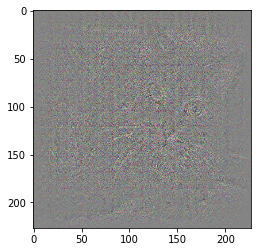

In [27]:
sess.run(tf.global_variables_initializer())
b = sess.run(out,feed_dict={X:img})
print(b.shape)
print(b[0])
plt.imshow(b[0])